libraries

libraries

In [ ]:

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import seaborn as sns

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
path_data=r"F:\\Work\\samples\\NLP\\IDMP\\In video\\a1_IMDB_Dataset.csv"
movie_review=pd.read_csv(path_data)
movie_review.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
movie_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
movie_review['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
movie_review['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [ ]:
Tag_re=re.compile(r'<[^>]+>')
def remove_tags(text):
    #removes HTML tages: replaces anything between opening and closing <> with empty space
    return Tag_re.sub('',text)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess(sen):
    sentence=sen.lower()
    sentence=remove_tags(sentence)
    sentence=re.sub('[^a-zA-Z]', ' ',sentence)
    sentence=re.sub(r'\s+[a-zA-Z]\s+' , ' ', sentence)
    sentence=re.sub(r'\s+',' ',sentence)
    pattern=re.compile(r'\b(' + r'|'.join(stopwords.words('english'))+r')\b\s+')
    sentence=pattern.sub('',sentence)
    return sentence

In [ ]:
X=[]
sentences= list(movie_review['review'])
for sen in tqdm(sentences):
    X.append(preprocess(sen))

100%|██████████| 50000/50000 [00:39<00:00, 1258.13it/s]


In [ ]:
y =movie_review['sentiment']
y=np.array(list(map(lambda x:1 if x=='positive' else 0 , y)))

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
#Convert text to the numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train= word_tokenizer.texts_to_sequences(X_train)
X_test= word_tokenizer.texts_to_sequences(X_test)

In [ ]:
vocab_length= len(word_tokenizer.word_index) +1
vocab_length

92440

In [ ]:
maxlen=100 
X_train=pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test=pad_sequences(X_test,padding='post',maxlen=maxlen)

In [ ]:
from numpy import asarray,zeros
embedding_dict=dict()
glove_file=open(r"F:\\Work\\samples\\NLP\\IDMP\\In video\\a2_glove.6B.100d.txt",encoding='utf8')
for line in tqdm(glove_file):
    records=line.split()
    word= records[0]
    vector_dimensions=asarray(records[1:],dtype='float32')
    embedding_dict[word]=vector_dimensions
glove_file.close()


400000it [00:13, 30387.69it/s]


In [ ]:
#make 100 column for word imbedding in glove

embedding_matrix=zeros((vocab_length,100))
for word,index in word_tokenizer.word_index.items():
    embedding_vector=embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(92440, 100)

In [ ]:
#neural network
snn_model = Sequential()
embedding_layer =Embedding(vocab_length,100 ,weights=[embedding_matrix],input_length=maxlen ,trainable=False)

snn_model.add(embedding_layer)
snn_model.add(Flatten())
snn_model.add(Dense(1,activation='sigmoid'))


In [ ]:
snn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(snn_model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     9,244,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,244,000 (35.26 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,244,000 (35.26 MB)

None


In [ ]:
snn_model_history=snn_model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - acc: 0.6714 - loss: 0.6028 - val_acc: 0.7630 - val_loss: 0.5023
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8012 - loss: 0.4396 - val_acc: 0.7636 - val_loss: 0.4945
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.8240 - loss: 0.4032 - val_acc: 0.7648 - val_loss: 0.4984
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8346 - loss: 0.3801 - val_acc: 0.7588 - val_loss: 0.5122
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8513 - loss: 0.3565 - val_acc: 0.7598 - val_loss: 0.5264
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8496 - loss: 0.3501 - val_acc: 0.7589 - val_loss: 0.5304


In [ ]:
score=snn_model.evaluate(X_test,y_test,verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7435 - loss: 0.5551


In [ ]:
print ('test score', score[0])
print ('test accuracy', score[1])

test score 0.5585041046142578
test accuracy 0.7470999956130981


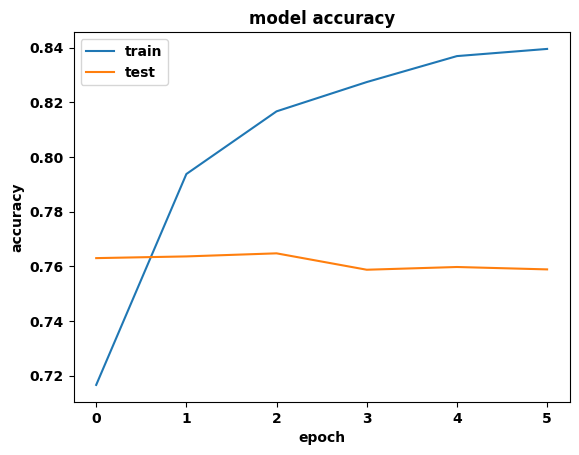

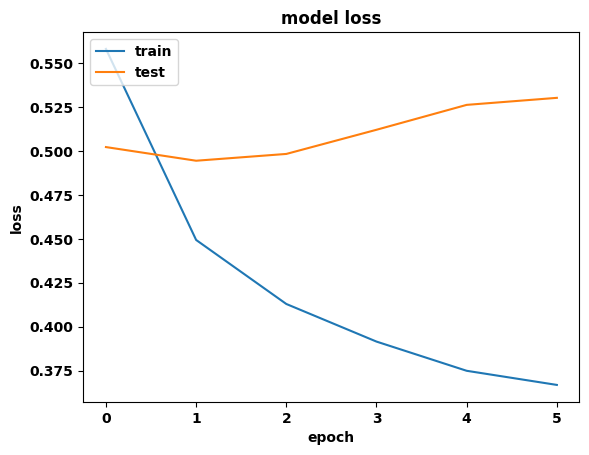

In [ ]:
import matplotlib.pyplot as plt
plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()


plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

CNN


In [ ]:
from tensorflow.keras.layers import Conv1D

In [ ]:
cnn_model=Sequential()
embedding_layer=Embedding(vocab_length,100 ,weights=[embedding_matrix],input_length=maxlen,trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128,5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1,activation='sigmoid'))

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
cnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     9,244,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,244,000 (35.26 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,244,000 (35.26 MB)

None


In [ ]:
cnn_model_history=cnn_model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - acc: 0.7081 - loss: 0.5552 - val_acc: 0.8374 - val_loss: 0.3752
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 108ms/step - acc: 0.8506 - loss: 0.3447 - val_acc: 0.8439 - val_loss: 0.3511
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - acc: 0.8910 - loss: 0.2785 - val_acc: 0.8529 - val_loss: 0.3340
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 118ms/step - acc: 0.9159 - loss: 0.2319 - val_acc: 0.8546 - val_loss: 0.3327
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - acc: 0.9394 - loss: 0.1905 - val_acc: 0.8534 - val_loss: 0.3304
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - acc: 0.9579 - loss: 0.1555 - val_acc: 0.8539 - val_loss: 0.3355


In [ ]:
score=cnn_model.evaluate(X_test,y_test,verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.8543 - loss: 0.3409


In [ ]:
print('test score', score[0])
print('test accuracy', score[1])

test score 0.34230345487594604
test accuracy 0.8514999747276306


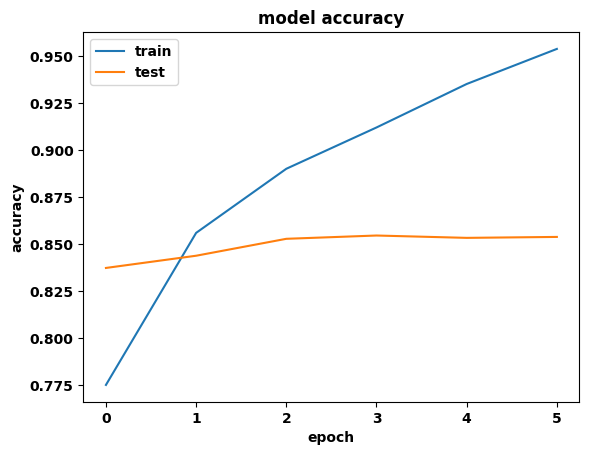

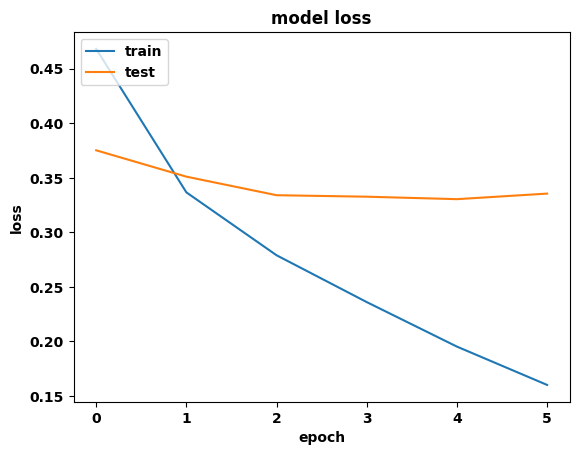

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

RNN(LSTM)

In [ ]:
from keras.layers import LSTM

In [ ]:
lstm_model=Sequential()
embedding_layer=Embedding(vocab_length,100,weights=[embedding_matrix],input_length=maxlen,trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1,activation='sigmoid'))

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
lstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │     9,244,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,244,000 (35.26 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,244,000 (35.26 MB)

None


In [ ]:
lstm_model_history=lstm_model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 137s 476ms/step - acc: 0.6608 - loss: 0.5981 - val_acc: 0.8039 - val_loss: 0.4440
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 336ms/step - acc: 0.8071 - loss: 0.4331 - val_acc: 0.8267 - val_loss: 0.3876
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 345ms/step - acc: 0.8293 - loss: 0.3836 - val_acc: 0.8396 - val_loss: 0.3744
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 350ms/step - acc: 0.8472 - loss: 0.3570 - val_acc: 0.8499 - val_loss: 0.3622
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 335ms/step - acc: 0.8616 - loss: 0.3279 - val_acc: 0.8637 - val_loss: 0.3226
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 319ms/step - acc: 0.8699 - loss: 0.3082 - val_acc: 0.8656 - val_loss: 0.3196


In [ ]:
score=lstm_model.evaluate(X_test,y_test,verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - acc: 0.8671 - loss: 0.3169


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3200143575668335
Test Accuracy: 0.8651000261306763


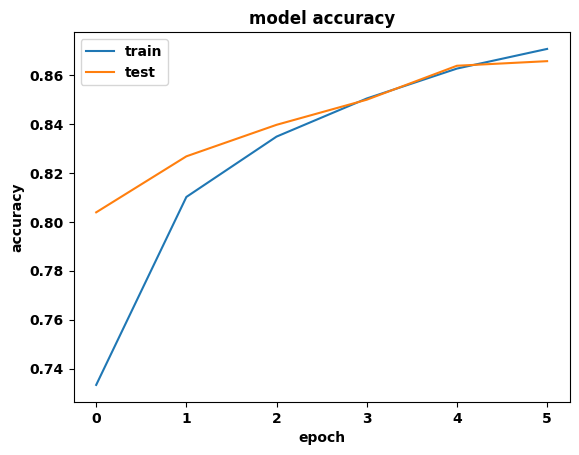

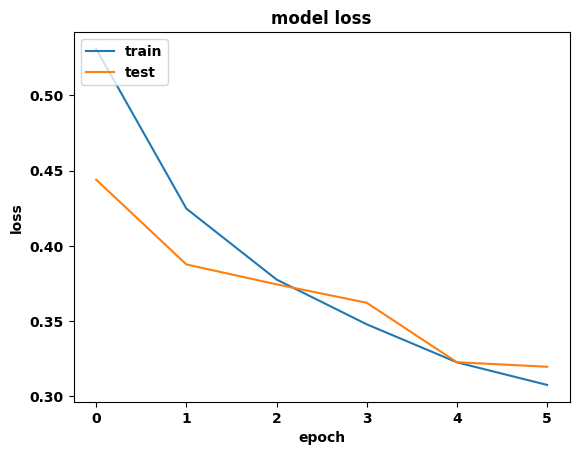

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

In [ ]:
# # Load previously trained LSTM Model

# from keras.models import load_model

# model_path ='c1_lstm_model_acc_0.856.h5'
# pretrained_lstm_model = load_model(model_path)

# # summarize model.
# pretrained_lstm_model.summary()

In [ ]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv(r"F:\Work\samples\\NLP\\IDMP\\In video\\a3_IMDb_Unseen_Reviews.csv")

sample_reviews


,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9.0
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10.0
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3.0
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1.0
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10.0
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3.0
6,6,Eternals,I was so intersted when I was watching the movie,NaN
7,7,Eternals,the movie was so boring,NaN


In [ ]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
    review = preprocess(review)
    unseen_processed.append(review)

In [ ]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


array([[0.9081044 ],
       [0.9920143 ],
       [0.09154059],
       [0.5644974 ],
       [0.9683528 ],
       [0.00947464],
       [0.5734936 ],
       [0.0261578 ]], dtype=float32)

In [ ]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9.0,9.1
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10.0,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3.0,0.9
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1.0,5.6
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10.0,9.7
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3.0,0.1
6,Eternals,I was so intersted when I was watching the movie,NaN,5.7
7,Eternals,the movie was so boring,NaN,0.3


In [9]:

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import seaborn as sns

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
path_data=r"F:\\Work\\samples\\NLP\\IDMP\\In video\\a1_IMDB_Dataset.csv"
movie_review=pd.read_csv(path_data)
movie_review.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
movie_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
movie_review['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [5]:
movie_review['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [6]:
Tag_re=re.compile(r'<[^>]+>')
def remove_tags(text):
    #removes HTML tages: replaces anything between opening and closing <> with empty space
    return Tag_re.sub('',text)

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def preprocess(sen):
    sentence=sen.lower()
    sentence=remove_tags(sentence)
    sentence=re.sub('[^a-zA-Z]', ' ',sentence)
    sentence=re.sub(r'\s+[a-zA-Z]\s+' , ' ', sentence)
    sentence=re.sub(r'\s+',' ',sentence)
    pattern=re.compile(r'\b(' + r'|'.join(stopwords.words('english'))+r')\b\s+')
    sentence=pattern.sub('',sentence)
    return sentence

In [10]:
X=[]
sentences= list(movie_review['review'])
for sen in tqdm(sentences):
    X.append(preprocess(sen))

100%|██████████| 50000/50000 [00:39<00:00, 1258.13it/s]


In [11]:
y =movie_review['sentiment']
y=np.array(list(map(lambda x:1 if x=='positive' else 0 , y)))

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
#Convert text to the numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train= word_tokenizer.texts_to_sequences(X_train)
X_test= word_tokenizer.texts_to_sequences(X_test)

In [19]:
vocab_length= len(word_tokenizer.word_index) +1
vocab_length

92440

In [22]:
maxlen=100 
X_train=pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test=pad_sequences(X_test,padding='post',maxlen=maxlen)

In [23]:
from numpy import asarray,zeros
embedding_dict=dict()
glove_file=open(r"F:\\Work\\samples\\NLP\\IDMP\\In video\\a2_glove.6B.100d.txt",encoding='utf8')
for line in tqdm(glove_file):
    records=line.split()
    word= records[0]
    vector_dimensions=asarray(records[1:],dtype='float32')
    embedding_dict[word]=vector_dimensions
glove_file.close()


400000it [00:13, 30387.69it/s]


In [24]:
#make 100 column for word imbedding in glove

embedding_matrix=zeros((vocab_length,100))
for word,index in word_tokenizer.word_index.items():
    embedding_vector=embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [25]:
embedding_matrix.shape

(92440, 100)

In [31]:
#neural network
snn_model = Sequential()
embedding_layer =Embedding(vocab_length,100 ,weights=[embedding_matrix],input_length=maxlen ,trainable=False)

snn_model.add(embedding_layer)
snn_model.add(Flatten())
snn_model.add(Dense(1,activation='sigmoid'))


In [32]:
snn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(snn_model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     9,244,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,244,000 (35.26 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,244,000 (35.26 MB)

None


In [33]:
snn_model_history=snn_model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - acc: 0.6714 - loss: 0.6028 - val_acc: 0.7630 - val_loss: 0.5023
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8012 - loss: 0.4396 - val_acc: 0.7636 - val_loss: 0.4945
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.8240 - loss: 0.4032 - val_acc: 0.7648 - val_loss: 0.4984
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8346 - loss: 0.3801 - val_acc: 0.7588 - val_loss: 0.5122
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8513 - loss: 0.3565 - val_acc: 0.7598 - val_loss: 0.5264
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8496 - loss: 0.3501 - val_acc: 0.7589 - val_loss: 0.5304


In [34]:
score=snn_model.evaluate(X_test,y_test,verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7435 - loss: 0.5551


In [35]:
print ('test score', score[0])
print ('test accuracy', score[1])

test score 0.5585041046142578
test accuracy 0.7470999956130981


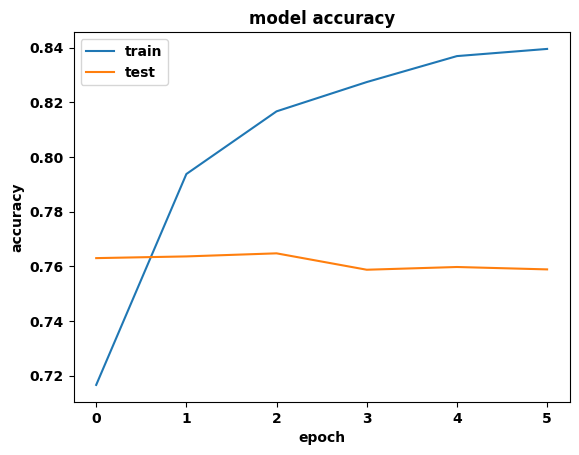

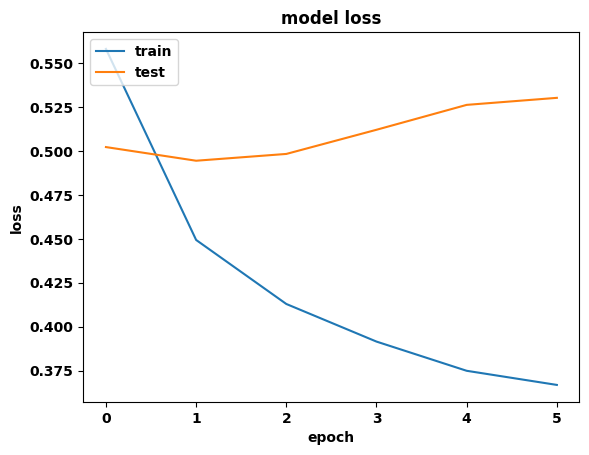

In [39]:
import matplotlib.pyplot as plt
plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()


plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

CNN


In [41]:
from tensorflow.keras.layers import Conv1D

In [44]:
cnn_model=Sequential()
embedding_layer=Embedding(vocab_length,100 ,weights=[embedding_matrix],input_length=maxlen,trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128,5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1,activation='sigmoid'))

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [45]:
cnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     9,244,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,244,000 (35.26 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,244,000 (35.26 MB)

None


In [46]:
cnn_model_history=cnn_model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - acc: 0.7081 - loss: 0.5552 - val_acc: 0.8374 - val_loss: 0.3752
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 108ms/step - acc: 0.8506 - loss: 0.3447 - val_acc: 0.8439 - val_loss: 0.3511
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - acc: 0.8910 - loss: 0.2785 - val_acc: 0.8529 - val_loss: 0.3340
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 118ms/step - acc: 0.9159 - loss: 0.2319 - val_acc: 0.8546 - val_loss: 0.3327
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - acc: 0.9394 - loss: 0.1905 - val_acc: 0.8534 - val_loss: 0.3304
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - acc: 0.9579 - loss: 0.1555 - val_acc: 0.8539 - val_loss: 0.3355


In [47]:
score=cnn_model.evaluate(X_test,y_test,verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.8543 - loss: 0.3409


In [48]:
print('test score', score[0])
print('test accuracy', score[1])

test score 0.34230345487594604
test accuracy 0.8514999747276306


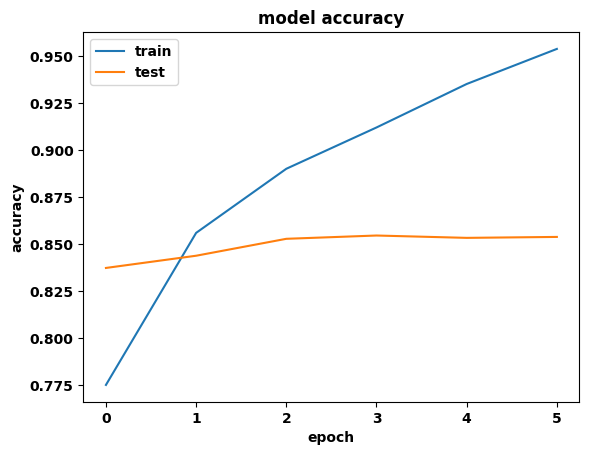

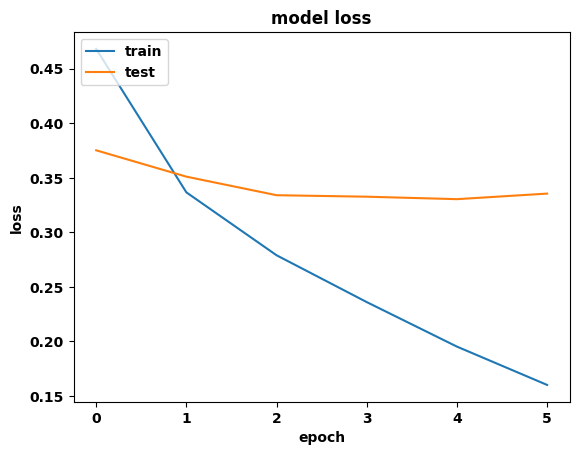

In [49]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

RNN(LSTM)

In [50]:
from keras.layers import LSTM

In [52]:
lstm_model=Sequential()
embedding_layer=Embedding(vocab_length,100,weights=[embedding_matrix],input_length=maxlen,trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1,activation='sigmoid'))

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [53]:
lstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │     9,244,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,244,000 (35.26 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,244,000 (35.26 MB)

None


In [54]:
lstm_model_history=lstm_model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 137s 476ms/step - acc: 0.6608 - loss: 0.5981 - val_acc: 0.8039 - val_loss: 0.4440
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 336ms/step - acc: 0.8071 - loss: 0.4331 - val_acc: 0.8267 - val_loss: 0.3876
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 345ms/step - acc: 0.8293 - loss: 0.3836 - val_acc: 0.8396 - val_loss: 0.3744
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 350ms/step - acc: 0.8472 - loss: 0.3570 - val_acc: 0.8499 - val_loss: 0.3622
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 335ms/step - acc: 0.8616 - loss: 0.3279 - val_acc: 0.8637 - val_loss: 0.3226
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 319ms/step - acc: 0.8699 - loss: 0.3082 - val_acc: 0.8656 - val_loss: 0.3196


In [55]:
score=lstm_model.evaluate(X_test,y_test,verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - acc: 0.8671 - loss: 0.3169


In [56]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3200143575668335
Test Accuracy: 0.8651000261306763


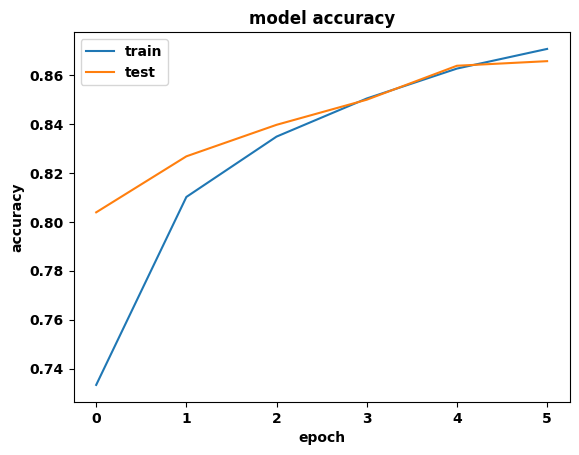

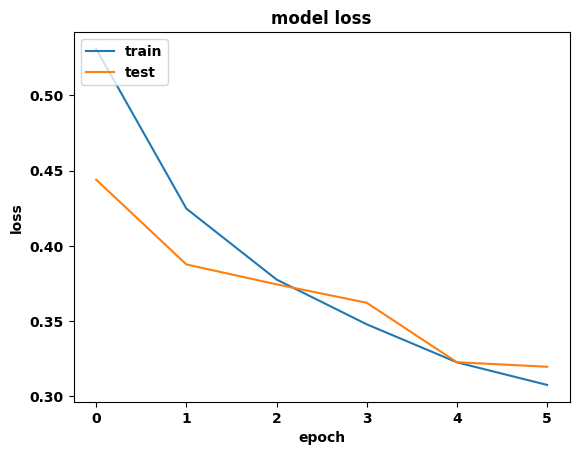

In [57]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [58]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

In [ ]:
# # Load previously trained LSTM Model

# from keras.models import load_model

# model_path ='c1_lstm_model_acc_0.856.h5'
# pretrained_lstm_model = load_model(model_path)

# # summarize model.
# pretrained_lstm_model.summary()

In [67]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv(r"F:\Work\samples\\NLP\\IDMP\\In video\\a3_IMDb_Unseen_Reviews.csv")

sample_reviews


,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9.0
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10.0
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3.0
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1.0
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10.0
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3.0
6,6,Eternals,I was so intersted when I was watching the movie,NaN
7,7,Eternals,the movie was so boring,NaN


In [68]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
    review = preprocess(review)
    unseen_processed.append(review)

In [69]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [70]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


array([[0.9081044 ],
       [0.9920143 ],
       [0.09154059],
       [0.5644974 ],
       [0.9683528 ],
       [0.00947464],
       [0.5734936 ],
       [0.0261578 ]], dtype=float32)

In [72]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9.0,9.1
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10.0,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3.0,0.9
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1.0,5.6
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10.0,9.7
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3.0,0.1
6,Eternals,I was so intersted when I was watching the movie,NaN,5.7
7,Eternals,the movie was so boring,NaN,0.3
